<a href="https://colab.research.google.com/github/ege-erdil/ww3-heatmap-improved/blob/main/ww3_heatmap_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --progress-bar off --quiet poetry
!pip install --progress-bar off --quiet git+https://github.com/oughtinc/ergo.git

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/BlankMap-Equirectangular.svg/1280px-BlankMap-Equirectangular.svg.png

In [ ]:
import ergo
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
from scipy.optimize import minimize
from math import pi

scale_factor = 1
k = 3

def gaussian_cross_entropy(param_list, distrib, log_distrib, param_num, distrib_len, m):
    result = 0
    total_mass = 1

    for i in range(param_num - 1):
      total_mass += np.exp(param_list[3*param_num + i])

    for x in range(distrib_len):
      curr_sum = 0
      for i in range(param_num):
        if i == 0:
          curr_sum += stats.norm.pdf(x, loc = param_list[3*i + m], scale = np.exp(param_list[3*i + 2]) * (m+1))/total_mass
        else:
          curr_sum += np.exp(param_list[3 * param_num + i - 1]) * stats.norm.pdf(x, loc = param_list[3*i + m], scale = np.exp(param_list[3*i + 2]) * (m+1))/total_mass
      result += -distrib[x] * (np.log(curr_sum) - log_distrib[x])

    return result

def objective(param_list, param_num):
    return scale_factor * (gaussian_cross_entropy(param_list, vertical_dist, log_vertical_dist, param_num, len(vertical_dist), 1) + gaussian_cross_entropy(param_list, horizontal_dist, log_horizontal_dist, param_num, len(horizontal_dist), 0))


metaculus = ergo.Metaculus()

height = 640
width = 1280

q_longitude = metaculus.get_question(3867, name="Longitude of WW3")
q_latitude = metaculus.get_question(3868, name="Latitude of WW3")

longitude_histogram = q_longitude.prediction_histogram
latitude_histogram = q_latitude.prediction_histogram

horizontal_dist = [x[2] for x in longitude_histogram]
horizontal_dist = horizontal_dist/np.sum(horizontal_dist)
log_horizontal_dist = np.log(horizontal_dist)

vertical_dist = [x[2] for x in latitude_histogram]
vertical_dist = vertical_dist/np.sum(vertical_dist)
log_vertical_dist = np.log(vertical_dist)



init_val = np.array(list(np.random.normal(loc = 100, scale = 10, size = 3*k)) + list(np.random.normal(loc = 0, scale = 0.1, size = k-1)))

for i in range(k):
  init_val[3*i + 2] = np.log(init_val[3*i + 2]/20)

res = minimize(objective, args = (k), method = "Powell", x0 = init_val, tol = 0.01)

print(res)

/usr/local/lib/python3.6/dist-packages/ergo/ppl.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


   direc: array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.        ],
       [  0.        ,   1.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   1.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.     

[223.43506996  73.54831484   4.80766088 163.13204009 134.23091358
   2.49510539 121.29080639 135.84187147   2.33247892   2.94692307
   2.66567084]


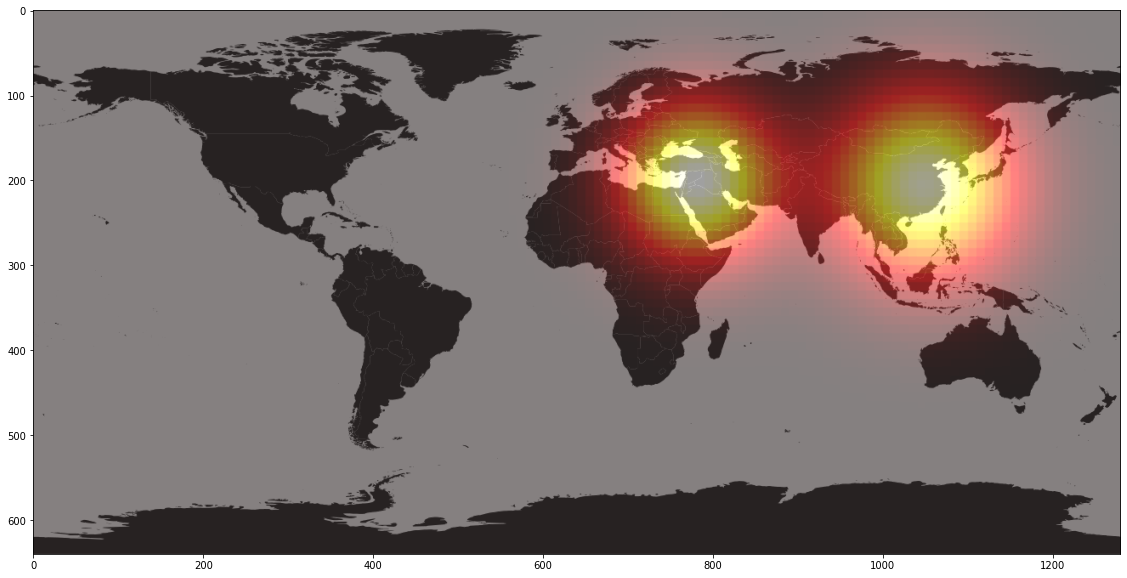

In [ ]:
final_parameters = res.x

print(final_parameters)

heatmap_array = np.zeros((height, width))
sum_val = 0

total_mass = 1
for i in range(k - 1):
      total_mass += np.exp(final_parameters[3*k + i])

for i in range(int(width/10)):
  for j in range(int(height/10)):
    curr_val = 0
    for n in range(k):
      if n == 0:
        curr_val += stats.norm.pdf(10 * i/width * 200, loc = final_parameters[3*n], scale = np.exp(final_parameters[3*n + 2])) * stats.norm.pdf(10 * j/height * 200, loc = final_parameters[3*n + 1], scale = 2 * np.exp(final_parameters[3*n + 2]))/total_mass
      else:
        curr_val += np.exp(final_parameters[3*k + n - 1]) * stats.norm.pdf(10 * i/width * 200, loc = final_parameters[3*n], scale = np.exp(final_parameters[3*n + 2])) * stats.norm.pdf(10 * j/height * 200, loc = final_parameters[3*n + 1], scale = 2 * np.exp(final_parameters[3*n + 2]))/total_mass
    sum_val += 100 * curr_val
    for u in range(10):
      for v in range(10):
        heatmap_array[height - 10*j - v - 1][10*i + u] = curr_val

heatmap_array = heatmap_array/sum_val

world_map = Image.open('1280px-BlankMap-Equirectangular.svg.png')

plt.figure(figsize=(20,10))
plt.imshow(world_map)
plt.imshow(heatmap_array, cmap='hot', interpolation='bicubic', alpha = 0.5)
plt.show()